# Data Loading and EDA

In [11]:
import pandas as pd

# Load the dataset
file_path = 'F:/PD_task/task/data/match_data.csv'
df = pd.read_csv(file_path)

# Display basic info and the first few rows
print(df.info())
print(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985274 entries, 0 to 985273
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   participation_id  985274 non-null  object 
 1   Time (s)          985274 non-null  float64
 2   Pitch_x           985274 non-null  float64
 3   Pitch_y           985274 non-null  float64
 4   Speed (m/s)       985274 non-null  float64
dtypes: float64(4), object(1)
memory usage: 37.6+ MB
None
                       participation_id  Time (s)    Pitch_x    Pitch_y  \
0  455426a2-5604-4c3a-8b89-ed0519f8d77a       0.0 -18.977667 -38.511021   
1  685d721f-fb27-4fb6-a327-6c8b420bf47f       0.0 -18.740459 -37.195089   
2  8d6885e6-bfa9-4561-820c-f80eac8d7f62       0.0 -14.467439 -38.767767   
3  455426a2-5604-4c3a-8b89-ed0519f8d77a       0.1 -18.977667 -38.511021   
4  685d721f-fb27-4fb6-a327-6c8b420bf47f       0.1 -18.737733 -37.179963   

   Speed (m/s)  
0        0.060  
1        0.

In [12]:
print(df['participation_id'].unique())
print(df['participation_id'].nunique())



['455426a2-5604-4c3a-8b89-ed0519f8d77a'
 '685d721f-fb27-4fb6-a327-6c8b420bf47f'
 '8d6885e6-bfa9-4561-820c-f80eac8d7f62'
 'b2d99dc2-6919-4c70-b381-6f89ca52048d'
 'd56ca4de-1be4-499a-8242-b219e051f33c'
 '3b7ea68d-8174-4061-94cc-84a07d488cfe'
 '0c7c551a-93df-416d-a892-81eccd50c6eb'
 'a7cc7c2e-350d-47a3-9d76-e40bc7cffa9e'
 '5f9839df-d91a-4ecd-b446-795329b174a5'
 'b4498a98-9d30-4f18-8cdf-884774505d34'
 '019d8fa9-3cbd-42f2-bfcf-1bc676d13e0f'
 '320d9832-0fdf-400e-b4e1-0d2b56144cf9'
 'a04c9fce-b4f1-4f7f-82be-ed9e8f21feb8'
 'bff73444-2e99-46e8-9bef-3a0cece74bab' 'ball'
 '33d4053e-34a9-4324-97a5-c17e8607d4c9'
 '48e50e40-2bc0-4a20-93cf-4683bcd13bf7']
17


 This shows 17 total entries, with 16 unique players and "ball" for one entry. This is not in line with 11 player system per team. Hence, assuming the data for 5 substitutes was also included.

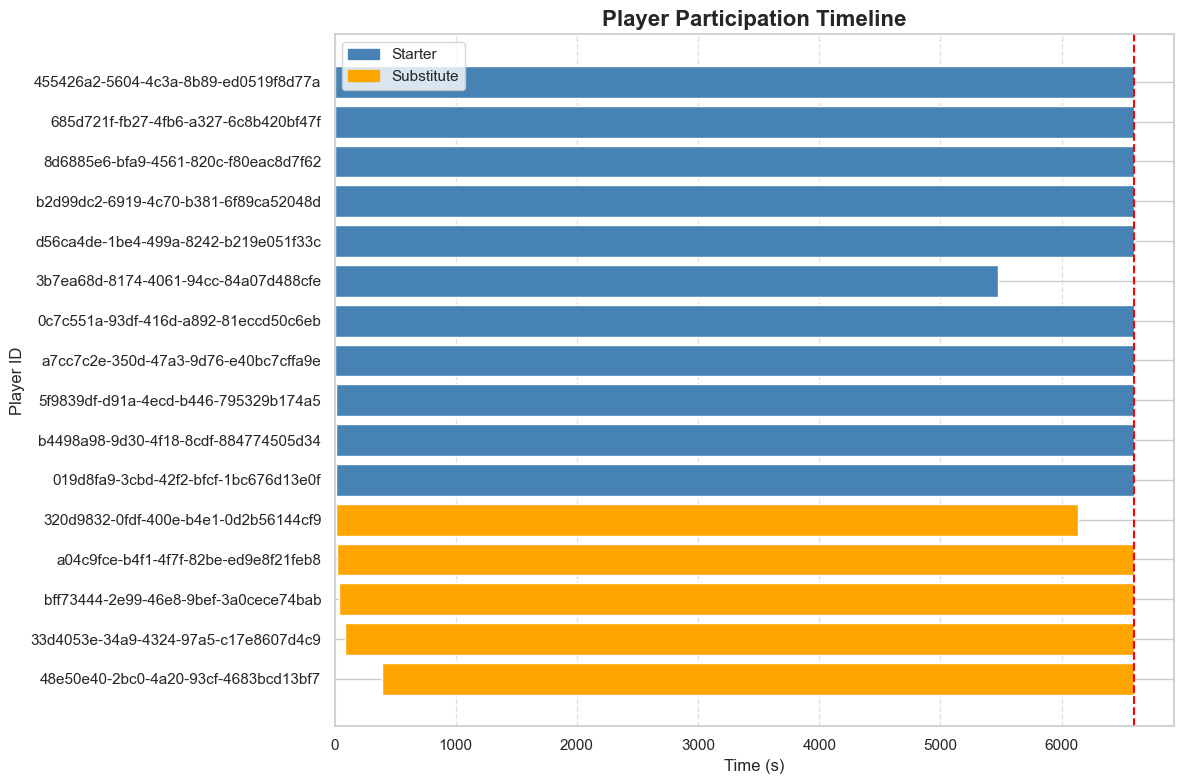

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load and Prepare the Data ---

players_df = df[df['participation_id'] != 'ball'].copy()

# Find the first and last appearance for each player
player_times = players_df.groupby('participation_id')['Time (s)'].agg(['min', 'max'])
player_times.rename(columns={'min': 'first_appearance', 'max': 'last_appearance'}, inplace=True)

# Identify starters (first 11 unique IDs) and subs
player_ids_by_appearance = players_df.drop_duplicates(subset='participation_id')['participation_id'].tolist()
starting_lineup_ids = player_ids_by_appearance[:11]

# Create a 'role' column for color-coding the plot
player_times['role'] = ['Starter' if idx in starting_lineup_ids else 'Substitute' for idx in player_times.index]

# Sort players by their first appearance time for a logical plot layout
player_times.sort_values(by='first_appearance', inplace=True)


# --- 2. Create the Timeline Visualization ---
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for roles
colors = {'Starter': '#4682B4', 'Substitute': '#FFA500'}

# Create a horizontal bar for each player representing their time on pitch
for player_id, row in player_times.iterrows():
    duration = row['last_appearance'] - row['first_appearance']
    ax.barh(
        y=player_id,
        width=duration,
        left=row['first_appearance'],
        color=colors[row['role']]
    )

# --- 3. Format the Plot for Clarity ---
ax.invert_yaxis()  # Display the first players at the top
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Player ID', fontsize=12)
ax.set_title('Player Participation Timeline', fontsize=16, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Add a vertical line for the match end time
match_end_time = players_df['Time (s)'].max()
ax.axvline(x=match_end_time, color='red', linestyle='--', label=f'Match End ({match_end_time:.2f}s)')

# Create a custom legend
legend_handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in colors]
ax.legend(legend_handles, colors.keys())

plt.tight_layout()
plt.show()

However, the hypothesis that 5 subsitutions were made proves to be wrong.

The match data recording ends at 6597.00s.

As you can see, only one player has a last_appearance time that is significantly different from the end of the match (5471.90s). The other 10 starting players all have data points recorded until the final second of the match.

This means that, according to the provided dataset, only one substitution of a starting player actually occurred. If there were 5 substitutions, it indicates an issue with the raw data, suggesting that the tracking data for the other four subbed-off players did not cut off when they left the field.

## Separating into different data frames for tracking player and ball movements

In [14]:
# Separate player data from ball data
players_df = df[df['participation_id'] != 'ball'].copy()
ball_df = df[df['participation_id'] == 'ball'].copy()

print(f"Total data points for players: {len(players_df)}")
print(f"Total data points for ball: {len(ball_df)}")

Total data points for players: 920042
Total data points for ball: 65232


## Filter data to keep it within pitch boundaries

In [15]:
# Define pitch boundaries
PITCH_X_MIN, PITCH_X_MAX = -52.5, 52.5
PITCH_Y_MIN, PITCH_Y_MAX = -34, 34

# Record original counts
initial_player_rows = len(players_df)
initial_ball_rows = len(ball_df)

# Apply the boundary filter
players_df = players_df[
    (players_df['Pitch_x'] >= PITCH_X_MIN) & (players_df['Pitch_x'] <= PITCH_X_MAX) &
    (players_df['Pitch_y'] >= PITCH_Y_MIN) & (players_df['Pitch_y'] <= PITCH_Y_MAX)
].copy()

ball_df = ball_df[
    (ball_df['Pitch_x'] >= PITCH_X_MIN) & (ball_df['Pitch_x'] <= PITCH_X_MAX) &
    (ball_df['Pitch_y'] >= PITCH_Y_MIN) & (ball_df['Pitch_y'] <= PITCH_Y_MAX)
].copy()

# Report the number of removed data points
print(f"Removed {initial_player_rows - len(players_df)} player data points outside pitch boundaries.")
print(f"Removed {initial_ball_rows - len(ball_df)} ball data points outside pitch boundaries.")

Removed 349180 player data points outside pitch boundaries.
Removed 6840 ball data points outside pitch boundaries.


## Noise reduction using a low-pass Butterworth Filter

In [16]:
import numpy as np
from scipy.signal import butter, filtfilt

# --- 1. Define Filter Parameters ---
fs = 10.0  # Sampling frequency
fc = 1.2   # Cutoff frequency
order = 2  # Filter order

# --- 2. Create the Filter ---
Wn = fc / (fs / 2) # Normalize frequency
b, a = butter(order, Wn, btype='low')

# --- 3. Apply the Filter to Each Player's data ---
# Using .transform ensures the output is the same shape as the input group
smoothed_x = players_df.groupby('participation_id')['Pitch_x'].transform(lambda x: filtfilt(b, a, x, padlen=len(x)-1))
smoothed_y = players_df.groupby('participation_id')['Pitch_y'].transform(lambda y: filtfilt(b, a, y, padlen=len(y)-1))

# padelen is used to prevent an error when a player has very few data points after filtering


# Add the smoothed coordinates to the dataframe
players_df['x_smooth'] = smoothed_x
players_df['y_smooth'] = smoothed_y

## Feature Engineering and Recalculating Metrics

In [17]:
# This function calculates kinematics for each player's data
def calculate_kinematics(player_data):
    delta_x = player_data['x_smooth'].diff()
    delta_y = player_data['y_smooth'].diff()
    delta_time = player_data['Time (s)'].diff()

    distance = np.sqrt(delta_x**2 + delta_y**2)
    
    # Recalculate speed
    player_data['speed_smooth'] = distance / delta_time
    
    # Calculate acceleration
    player_data['acceleration'] = player_data['speed_smooth'].diff() / delta_time

    # Fill any resulting NaNs
    player_data = player_data.fillna(0)
    
    return player_data

# Apply the function to each player group
players_df = players_df.groupby('participation_id', group_keys=False).apply(calculate_kinematics)

# Check the new columns
print("\nFinal preprocessed data with new metrics:")
print(players_df[['Time (s)', 'participation_id', 'Speed (m/s)', 'speed_smooth', 'acceleration']].head(10))


Final preprocessed data with new metrics:
    Time (s)                      participation_id  Speed (m/s)  speed_smooth  \
9        0.2  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.03900      0.000000   
13       0.3  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.03400      2.206217   
17       0.4  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.00700      2.033811   
21       0.5  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.05200      1.773622   
25       0.6  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.04600      1.558918   
29       0.7  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.03800      1.394064   
33       0.8  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.08100      1.233110   
37       0.9  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.06625      1.081301   
41       1.0  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.05150      1.047979   
45       1.1  b2d99dc2-6919-4c70-b381-6f89ca52048d      0.03000      1.234631   

    acceleration  
9       0.000000  
13      0.000000  
17     -

C:\Users\upama\AppData\Local\Temp\ipykernel_8092\452623741.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  players_df = players_df.groupby('participation_id', group_keys=False).apply(calculate_kinematics)


# Analysis by combining both speed and positioning data 


C:\Users\upama\AppData\Local\Temp\ipykernel_8092\2875452905.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pressing_counts = players_df.groupby('participation_id').apply(
C:\Users\upama\AppData\Local\Temp\ipykernel_8092\2875452905.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entries = in_box_and_sprinting['in_box'] & ~in_box_and_sprinting['in_box'].shift(1).fillna(False)
C:\Users\upama\AppData\Local\Temp\ipykernel_8092\2875452905.py:62: FutureWarning: Downcasting object d

##  Pressing-Intensity (Top 5 Players)
| participation_id                     |   Pressing Actions |
|:-------------------------------------|-------------------:|
| 5f9839df-d91a-4ecd-b446-795329b174a5 |                401 |
| a04c9fce-b4f1-4f7f-82be-ed9e8f21feb8 |                381 |
| b4498a98-9d30-4f18-8cdf-884774505d34 |                362 |
| 48e50e40-2bc0-4a20-93cf-4683bcd13bf7 |                221 |
| d56ca4de-1be4-499a-8242-b219e051f33c |                219 |


C:\Users\upama\AppData\Local\Temp\ipykernel_8092\2875452905.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entries = in_box_and_sprinting['in_box'] & ~in_box_and_sprinting['in_box'].shift(1).fillna(False)
C:\Users\upama\AppData\Local\Temp\ipykernel_8092\2875452905.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  entries = in_box_and_sprinting['in_box'] & ~in_box_and_sprinting['in_box'].shift(1).fillna(False)
C:\Users\upama\AppData\Local\Temp\ipykernel_8092\2875452905.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfi


## Individual Performance: Sprints into the Penalty Box (Top 5)
| participation_id                     |   Sprints into Box |
|:-------------------------------------|-------------------:|
| 5f9839df-d91a-4ecd-b446-795329b174a5 |                 21 |
| b2d99dc2-6919-4c70-b381-6f89ca52048d |                  3 |
| 8d6885e6-bfa9-4561-820c-f80eac8d7f62 |                  2 |
| d56ca4de-1be4-499a-8242-b219e051f33c |                  2 |
| 48e50e40-2bc0-4a20-93cf-4683bcd13bf7 |                  1 |

## Work-Rate Profile for Player: b2d99dc2-6919-4c70-b381-6f89ca52048d
Generating speed heatmap...


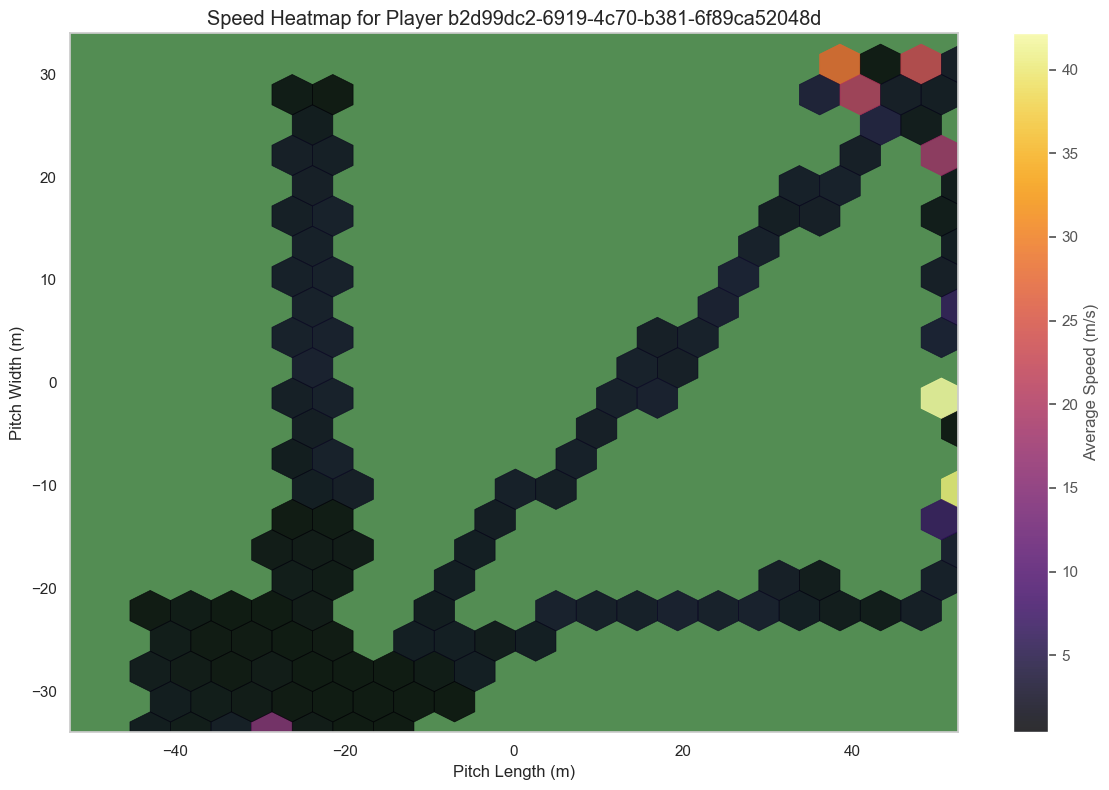

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Setup: Define thresholds and pitch zones ---
# Using the pre-calculated 'speed_smooth' for all analyses.
HIGH_SPEED_THRESHOLD = 5.5  # m/s (approx 20 km/h), for high-intensity runs
SPRINT_THRESHOLD = 7.0      # m/s (approx 25 km/h), for sprinting

# Define pitch zones for tactical analysis
PITCH_LENGTH = 105
PITCH_WIDTH = 68
ATTACKING_THIRD_LINE = PITCH_LENGTH / 6  # Line for the attacking third
PENALTY_BOX_X_MIN = PITCH_LENGTH / 2 - 16.5
PENALTY_BOX_X_MAX = PITCH_LENGTH / 2
PENALTY_BOX_Y_MIN = -20.15
PENALTY_BOX_Y_MAX = 20.15

# Let's select one player for detailed individual analysis
player_to_analyze = players_df['participation_id'].unique()[0]
player_data = players_df[players_df['participation_id'] == player_to_analyze]


# --- 1. Tactical Analysis: Pressing Intensity ---
# We can identify high-speed pressing actions by counting high-speed runs in the attacking third.
def analyze_pressing(df, speed_thresh, zone_thresh):
    """Counts high-speed runs in the attacking third of the pitch."""
    # A high-speed run in the attacking third is a potential pressing action
    pressing_actions = df[
        (df['speed_smooth'] > speed_thresh) &
        (df['x_smooth'] > zone_thresh)
    ]
    return len(pressing_actions)

# Calculate pressing actions for all players
pressing_counts = players_df.groupby('participation_id').apply(
    analyze_pressing, speed_thresh=HIGH_SPEED_THRESHOLD, zone_thresh=ATTACKING_THIRD_LINE
)
pressing_leaderboard = pressing_counts.reset_index(name='Pressing Actions').sort_values(by='Pressing Actions', ascending=False)

print("="*60)
print("##  Pressing-Intensity (Top 5 Players)")
print("="*60)
print(pressing_leaderboard.head().to_markdown(index=False))


# --- 2. Individual Performance: High-Impact Runs into the Penalty Box ---
# This identifies a player's threat level by counting sprints that enter the opponent's box.
def count_sprints_into_box(p_data, speed_thresh, box_x_min, box_y_min, box_y_max):
    """Counts the number of times a player sprints into the penalty box."""
    # Find points where the player is inside the box and sprinting
    in_box_and_sprinting = p_data[
        (p_data['speed_smooth'] > speed_thresh) &
        (p_data['x_smooth'] > box_x_min) &
        (p_data['y_smooth'] > box_y_min) &
        (p_data['y_smooth'] < box_y_max)
    ]
    # To count entries, we check when the 'in_box' status changes from False to True
    in_box_and_sprinting['in_box'] = True
    in_box_and_sprinting = in_box_and_sprinting.reindex(p_data.index, fill_value=False)
    # A run enters the box when the previous state was False and the current is True
    entries = in_box_and_sprinting['in_box'] & ~in_box_and_sprinting['in_box'].shift(1).fillna(False)
    return entries.sum()

sprints_into_box = players_df.groupby('participation_id').apply(
    count_sprints_into_box,
    speed_thresh=SPRINT_THRESHOLD,
    box_x_min=PENALTY_BOX_X_MIN,
    box_y_min=PENALTY_BOX_Y_MIN,
    box_y_max=PENALTY_BOX_Y_MAX
)
box_entry_leaderboard = sprints_into_box.reset_index(name='Sprints into Box').sort_values(by='Sprints into Box', ascending=False)

print("\n" + "="*60)
print("## Individual Performance: Sprints into the Penalty Box (Top 5)")
print("="*60)
print(box_entry_leaderboard.head().to_markdown(index=False))


# --- 3. Individual Work-Rate Profile: Speed-Encoded Heatmap ---
# This visualizes NOT just where a player was, but HOW FAST they were moving in those areas.
print(f"\n" + "="*60)
print(f"## Work-Rate Profile for Player: {player_to_analyze}")
print("="*60)
print("Generating speed heatmap...")

# Create a figure for the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use('ggplot')

# Use a 2D histogram (hexbin) to plot the player's position.
# The 'C' parameter aggregates a third value (speed_smooth) for each bin.
# 'reduce_C_function=np.mean' means the color of each hexagon will be the AVERAGE speed in that area.
hb = ax.hexbin(
    player_data['x_smooth'],
    player_data['y_smooth'],
    C=player_data['speed_smooth'],
    reduce_C_function=np.mean,
    gridsize=20,
    cmap='inferno',
    alpha=0.8
)

# Add a color bar to show the speed scale
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Average Speed (m/s)')

# Set pitch boundaries and labels
ax.set_xlim(-PITCH_LENGTH / 2, PITCH_LENGTH / 2)
ax.set_ylim(-PITCH_WIDTH / 2, PITCH_WIDTH / 2)
ax.set_title(f'Speed Heatmap for Player {player_to_analyze}')
ax.set_xlabel('Pitch Length (m)')
ax.set_ylabel('Pitch Width (m)')

# Make the plot look more like a pitch
ax.set_facecolor('#538d53') # Green background
plt.grid(False)
plt.tight_layout()
plt.show()

# Generating Leaderboards

In [19]:
# --- 1. Leaderboard: Top 5 Players by Total Distance Covered ---

# The distance covered is the sum of the small distances between each consecutive point.
def calculate_total_distance(player_data):
    """Calculates the total distance covered by a single player from smoothed coordinates."""
    delta_x = player_data['x_smooth'].diff()
    delta_y = player_data['y_smooth'].diff()
    # Calculate the distance for each time step
    distance_per_step = np.sqrt(delta_x**2 + delta_y**2)
    # Return the sum of all distances for that player
    return distance_per_step.sum()

# Group the dataframe by player and apply the distance calculation function
total_distances = players_df.groupby('participation_id').apply(calculate_total_distance)

# Create a clean dataframe, sort it, and select the top 5
distance_leaderboard = total_distances.reset_index(name='Total Distance (m)')
distance_leaderboard_top5 = distance_leaderboard.sort_values(by='Total Distance (m)', ascending=False).head(5)


# --- 2. Leaderboard: Top 5 Players by Sprinting Distance (Speed Zone 5) ---

# Define the speed zone boundaries in m/s
ZONE_LOWER_BOUND_MS = 19.8 * (5 / 18)  # Approximately 5.5 m/s
ZONE_UPPER_BOUND_MS = 25.1 * (5 / 18)  # Approximately 6.97 m/s

def calculate_distance_in_speed_zone(player_data):
    """Calculates the distance a player covered within a specific speed zone."""

    # 1. First, calculate the distance covered between each consecutive point
    delta_x = player_data['x_smooth'].diff()
    delta_y = player_data['y_smooth'].diff()
    distance_per_step = np.sqrt(delta_x**2 + delta_y**2)

    # 2. Next, identify the moments where the player's speed was WITHIN the defined zone
    is_in_zone = (player_data['speed_smooth'] >= ZONE_LOWER_BOUND_MS) & \
                 (player_data['speed_smooth'] <= ZONE_UPPER_BOUND_MS)

    # 3. Finally, sum the distances ONLY for the steps where the player was in the zone
    zone_distance = distance_per_step[is_in_zone].sum()

    return zone_distance


# Group the dataframe by player and apply the sprinting distance calculation
sprinting_distances = players_df.groupby('participation_id').apply(calculate_distance_in_speed_zone)

# Create a clean dataframe, sort it, and select the top 5
sprinting_leaderboard = sprinting_distances.reset_index(name='Sprinting Distance (m)')
sprinting_leaderboard_top5 = sprinting_leaderboard.sort_values(by='Sprinting Distance (m)', ascending=False).head(5)


# --- 3. Leaderboard: Top 5 Players by Top Speed ---

top_speeds = players_df.groupby('participation_id')['speed_smooth'].max()

# Create a clean dataframe, sort it, and select the top 5
speed_leaderboard = top_speeds.reset_index(name='Top Speed (m/s)')
speed_leaderboard_top5 = speed_leaderboard.sort_values(by='Top Speed (m/s)', ascending=False).head(5)


# change head(n) to adjust to the number required in the leaderboard

# --- Display the Final Leaderboards ---

print("\n\n" + "="*50)
print("## Leaderboard: Top 5 Players by Total Distance Covered")
print("="*50)
print(distance_leaderboard_top5.to_markdown(index=False, floatfmt=".2f"))

print("\n" + "="*50)
print("## Leaderboard: Top 5 Players by Sprinting Distance (Zone 5)")
print("="*50)
print(sprinting_leaderboard_top5.to_markdown(index=False, floatfmt=".2f"))

print("\n" + "="*50)
print("## Leaderboard: Top 5 Players by Top Speed")
print("="*50)
print(speed_leaderboard_top5.to_markdown(index=False, floatfmt=".2f"))

C:\Users\upama\AppData\Local\Temp\ipykernel_8092\1495394529.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_distances = players_df.groupby('participation_id').apply(calculate_total_distance)
C:\Users\upama\AppData\Local\Temp\ipykernel_8092\1495394529.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sprinting_distances = players_df.groupby('participation_id').apply(calculate_distance_in_speed_zone)




## Leaderboard: Top 5 Players by Total Distance Covered
| participation_id                     |   Total Distance (m) |
|:-------------------------------------|---------------------:|
| a04c9fce-b4f1-4f7f-82be-ed9e8f21feb8 |             10866.17 |
| a7cc7c2e-350d-47a3-9d76-e40bc7cffa9e |             10259.07 |
| d56ca4de-1be4-499a-8242-b219e051f33c |             10184.67 |
| b4498a98-9d30-4f18-8cdf-884774505d34 |              9998.19 |
| 019d8fa9-3cbd-42f2-bfcf-1bc676d13e0f |              8906.72 |

## Leaderboard: Top 5 Players by Sprinting Distance (Zone 5)
| participation_id                     |   Sprinting Distance (m) |
|:-------------------------------------|-------------------------:|
| a04c9fce-b4f1-4f7f-82be-ed9e8f21feb8 |                   782.71 |
| b4498a98-9d30-4f18-8cdf-884774505d34 |                   721.64 |
| 019d8fa9-3cbd-42f2-bfcf-1bc676d13e0f |                   405.66 |
| d56ca4de-1be4-499a-8242-b219e051f33c |                   398.55 |
| 5f9839df-d91a-4ecd-b44

C:\Users\upama\AppData\Local\Temp\ipykernel_8092\3805696858.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


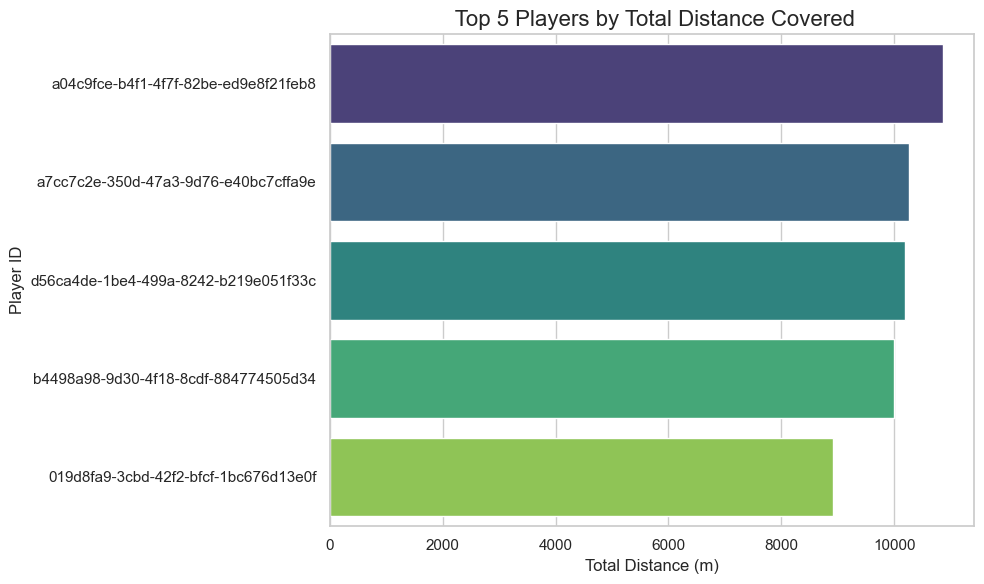

C:\Users\upama\AppData\Local\Temp\ipykernel_8092\3805696858.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(


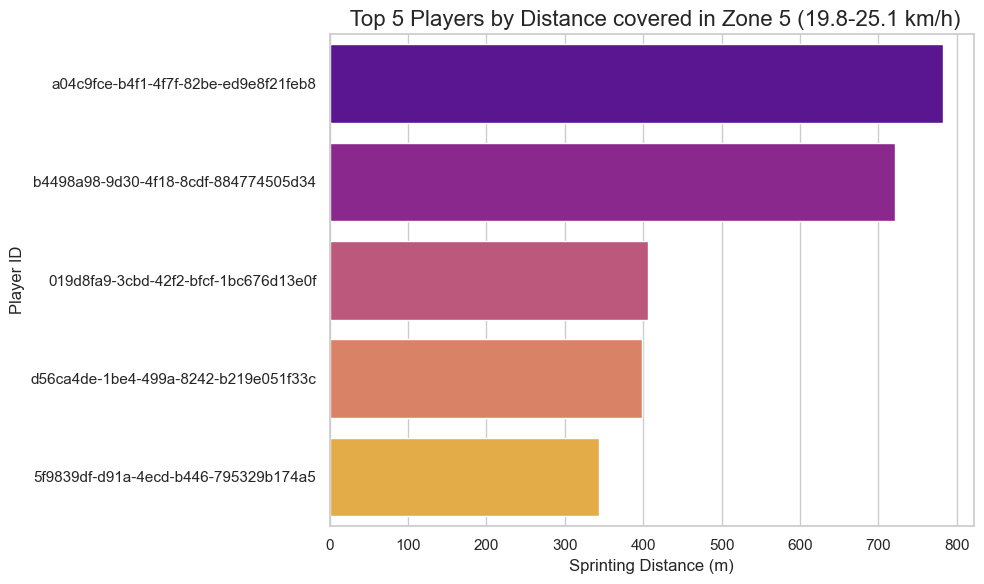

C:\Users\upama\AppData\Local\Temp\ipykernel_8092\3805696858.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax3 = sns.barplot(


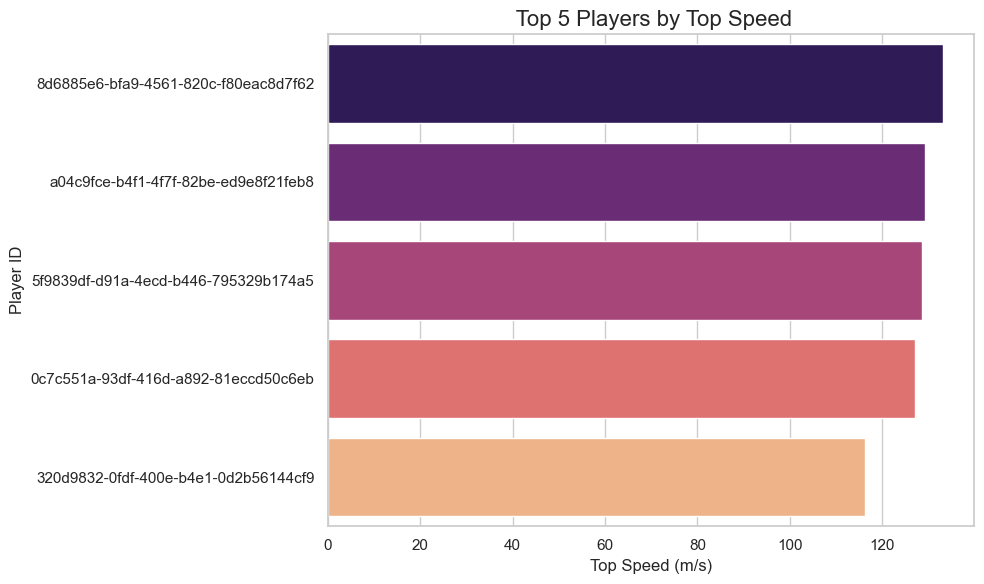

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

# --- 1. Plot for Total Distance Covered ---
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(
    x='Total Distance (m)',
    y='participation_id',
    data=distance_leaderboard_top5,
    palette='viridis',
    orient='h' # Horizontal bar plot
)
ax1.set_title(' Top 5 Players by Total Distance Covered', fontsize=16)
ax1.set_xlabel('Total Distance (m)', fontsize=12)
ax1.set_ylabel('Player ID', fontsize=12)
plt.tight_layout()
plt.show()


# --- 2. Plot for Sprinting Distance (Zone 5) ---
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(
    x='Sprinting Distance (m)',
    y='participation_id',
    data=sprinting_leaderboard_top5,
    palette='plasma',
    orient='h'
)
ax2.set_title(' Top 5 Players by Distance covered in Zone 5 (19.8-25.1 km/h)', fontsize=16)
ax2.set_xlabel('Sprinting Distance (m)', fontsize=12)
ax2.set_ylabel('Player ID', fontsize=12)
plt.tight_layout()
plt.show()


# --- 3. Plot for Top Speed ---
plt.figure(figsize=(10, 6))
ax3 = sns.barplot(
    x='Top Speed (m/s)',
    y='participation_id',
    data=speed_leaderboard_top5,
    palette='magma',
    orient='h'
)
ax3.set_title(' Top 5 Players by Top Speed', fontsize=16)
ax3.set_xlabel('Top Speed (m/s)', fontsize=12)
ax3.set_ylabel('Player ID', fontsize=12)
plt.tight_layout()
plt.show()

# Visuals and Ball Interactions

## Heatmap Analysis

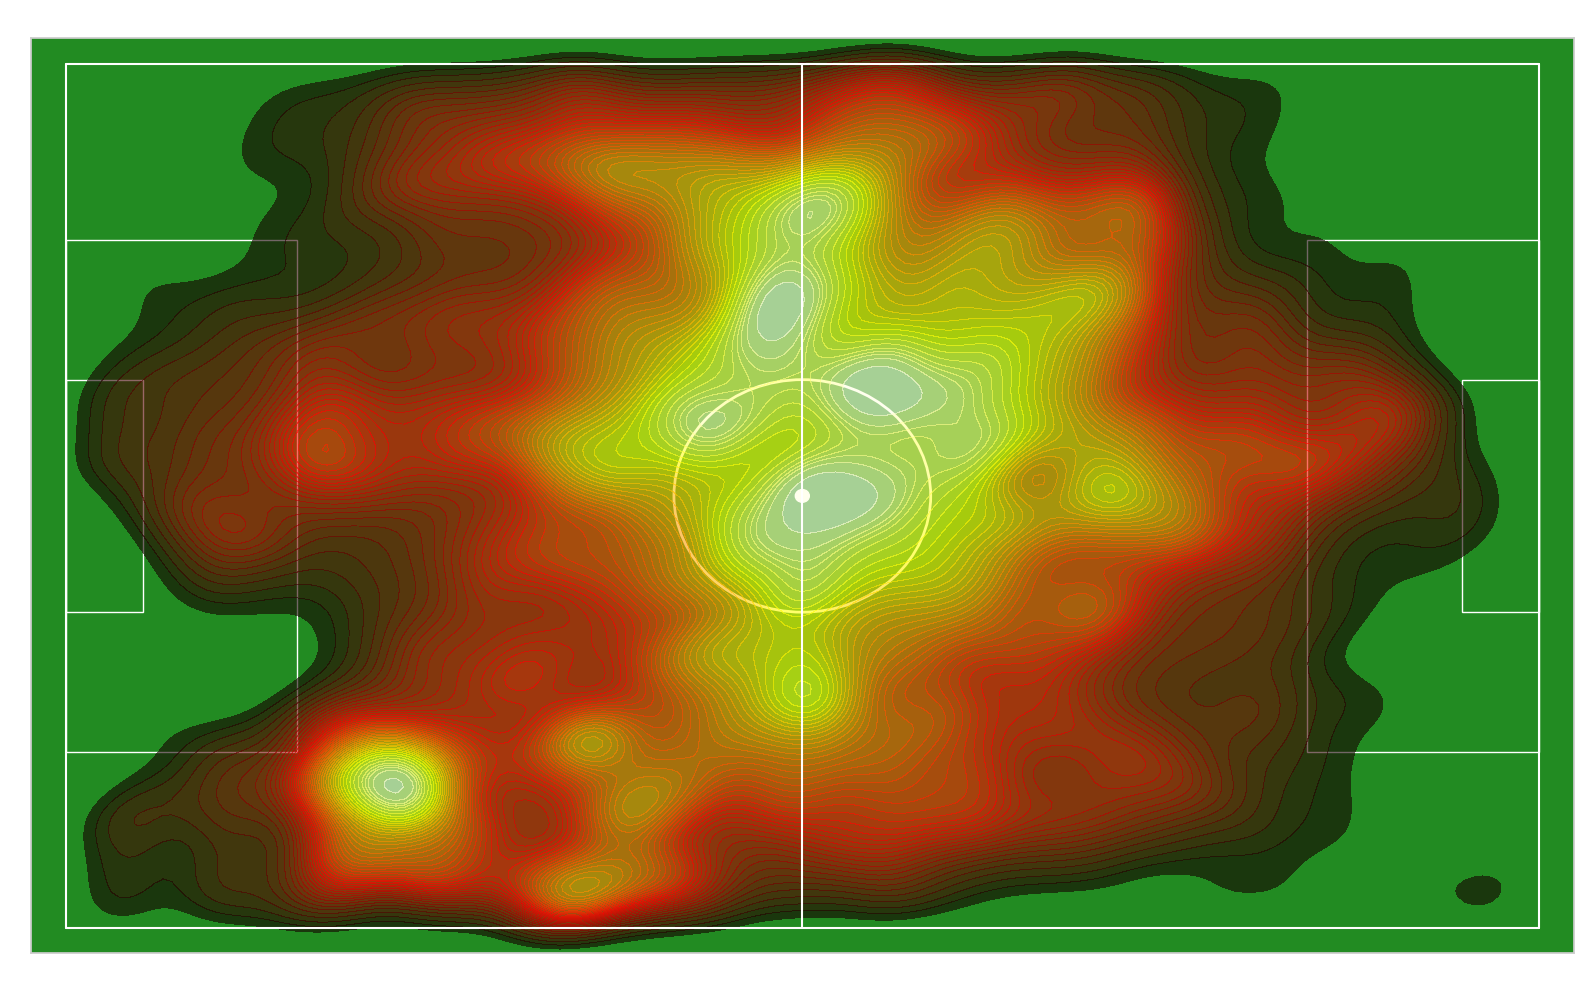

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc, Rectangle, Circle

def draw_pitch(ax, pitch_color='#228B22', line_color='white'):
    """
    Draws a football pitch on a matplotlib axes object.
    """
    ax.set_facecolor(pitch_color)
    
    # Pitch Outline & Halfway Line
    ax.plot([0, 0], [-34, 34], color=line_color) # Halfway line
    ax.plot([-52.5, 52.5], [-34, -34], color=line_color) # Bottom line
    ax.plot([-52.5, 52.5], [34, 34], color=line_color)   # Top line
    ax.plot([-52.5, -52.5], [-34, 34], color=line_color) # Left line
    ax.plot([52.5, 52.5], [-34, 34], color=line_color)   # Right line
    
    # Center Circle
    center_circle = Circle((0.0, 0.0), 9.15, edgecolor=line_color, facecolor='none', lw=2)
    ax.add_patch(center_circle)
    center_dot = Circle((0.0, 0.0), 0.5, color=line_color)
    ax.add_patch(center_dot)
    
    # Penalty Areas
    ax.add_patch(Rectangle((-52.5, -20.15), 16.5, 40.3, edgecolor=line_color, facecolor='none'))
    ax.add_patch(Rectangle((36, -20.15), 16.5, 40.3, edgecolor=line_color, facecolor='none'))
    
    # 6-yard Box
    ax.add_patch(Rectangle((-52.5, -9.16), 5.5, 18.32, edgecolor=line_color, facecolor='none'))
    ax.add_patch(Rectangle((47, -9.16), 5.5, 18.32, edgecolor=line_color, facecolor='none'))

    return ax

# --- 1. Create the Plot ---
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 10))
plt.style.use('dark_background')

# --- 2. Draw the Pitch ---
# Use the function to draw a pitch as the background
ax = draw_pitch(ax)

# --- 3. Generate and Overlay the Heatmap ---
# Using seaborn's Kernel Density Estimate (KDE) plot for a smooth heatmap.
sns.kdeplot(
    x=players_df['x_smooth'],
    y=players_df['y_smooth'],
    fill=True,
    cmap="hot",
    n_levels=50,
    alpha=0.6,  # Set transparency to see the pitch lines underneath
    ax=ax
)

# --- 4. Final Touches ---
ax.set_xlim(-55, 55)
ax.set_ylim(-36, 36)
ax.set_title('Team Positional Heatmap', fontsize=20, color='white')
ax.set_xlabel('Pitch Length (m)', color='white')
ax.set_ylabel('Pitch Width (m)', color='white')

# Remove axis ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

## Ball Data Integration

### Passing Network

This is done by assuming the player positioned closest to the ball is the one in possession. 

## Detecting Passes...
Detected 160 potential passes.

## Generating Passing Network Visualization...


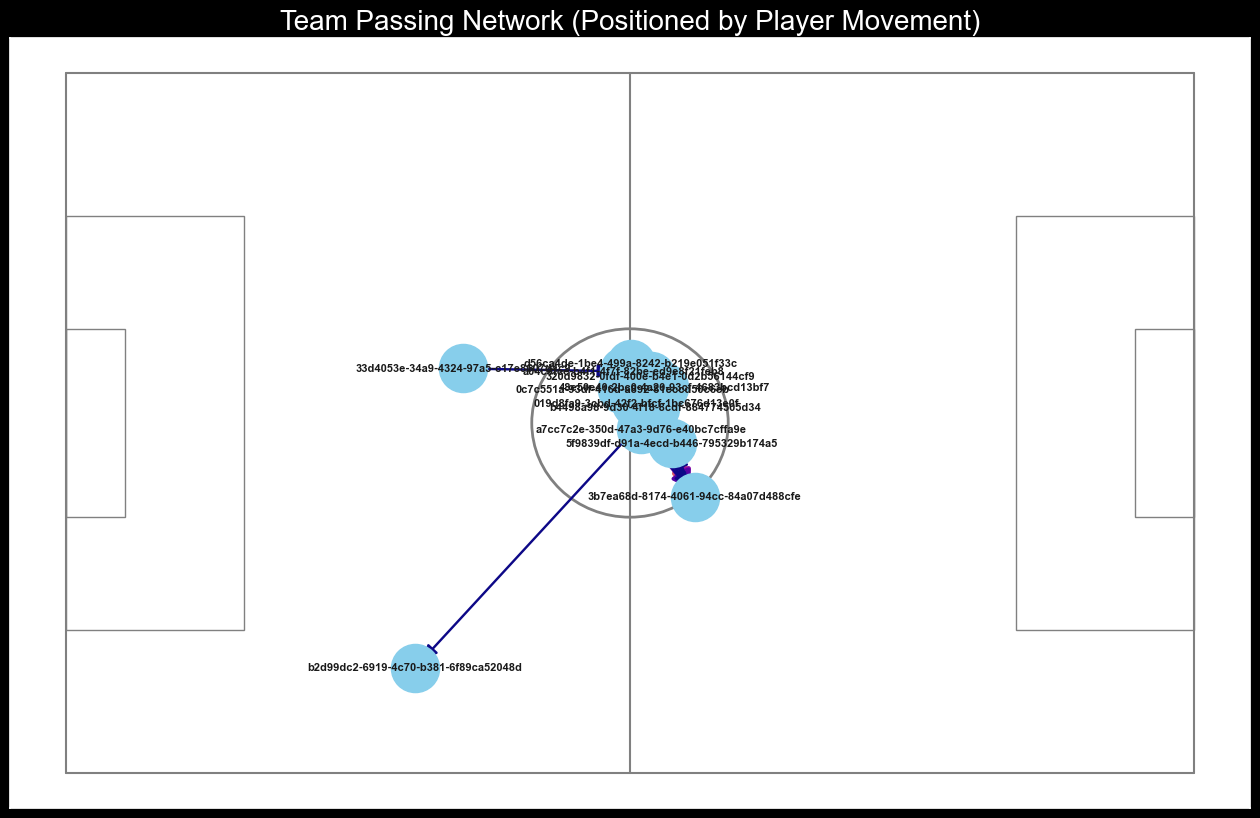

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, find_peaks
from scipy.spatial import ConvexHull
import networkx as nx
from matplotlib.patches import Arc, Rectangle, Circle



# --- Part 0: Data Preparation ---
# 1. Isolate and smooth ball data
ball_df = df[df['participation_id'] == 'ball'].copy()
fs = 10.0
fc = 1.2
order = 2
Wn = fc / (fs / 2)
b, a = butter(order, Wn, btype='low')
ball_df['x_smooth'] = filtfilt(b, a, ball_df['Pitch_x'])
ball_df['y_smooth'] = filtfilt(b, a, ball_df['Pitch_y'])

# 2. Get the list of all player IDs
player_ids = players_df['participation_id'].unique()

# 3. Combine player and ball data for pass detection
player_positions = players_df.pivot_table(
    index='Time (s)', columns='participation_id', values=['x_smooth', 'y_smooth']
)
player_positions.ffill(inplace=True)

ball_positions = ball_df.set_index('Time (s)')[['x_smooth', 'y_smooth']]
ball_positions.columns = pd.MultiIndex.from_tuples([('ball_x', ''), ('ball_y', '')])
full_tracking_df = player_positions.join(ball_positions, how='inner')


# --- Part 1: Pass Detection ---
print("="*60)
print("## Detecting Passes...")
print("="*60)

delta_x = ball_df['x_smooth'].diff()
delta_y = ball_df['y_smooth'].diff()
delta_time = ball_df['Time (s)'].diff()
ball_df['speed_smooth'] = np.sqrt(delta_x**2 + delta_y**2) / delta_time
ball_df.fillna(0, inplace=True)

peaks, _ = find_peaks(ball_df['speed_smooth'], height=8, distance=15)
passes = []
for peak_idx in peaks:
    try:
        time_of_kick = ball_df.iloc[peak_idx]['Time (s)']
        window = full_tracking_df.loc[time_of_kick-1:time_of_kick+3]
        
        pre_kick_positions = window.loc[time_of_kick-0.5:time_of_kick-0.1]
        player_dist_before = {
            pid: np.mean(np.sqrt((pre_kick_positions[('x_smooth', pid)] - pre_kick_positions[('ball_x', '')])**2 + \
                                 (pre_kick_positions[('y_smooth', pid)] - pre_kick_positions[('ball_y', '')])**2))
            for pid in player_ids
        }
        sender = min(player_dist_before, key=player_dist_before.get)
        
        post_kick_positions = window.loc[time_of_kick+1:time_of_kick+2.5]
        player_dist_after = {
            pid: np.mean(np.sqrt((post_kick_positions[('x_smooth', pid)] - post_kick_positions[('ball_x', '')])**2 + \
                                (post_kick_positions[('y_smooth', pid)] - post_kick_positions[('ball_y', '')])**2))
            for pid in player_ids
        }
        receiver = min(player_dist_after, key=player_dist_after.get)
        
        if sender != receiver:
            passes.append((sender, receiver))
            
    except (KeyError, IndexError):
        continue

print(f"Detected {len(passes)} potential passes.")

# --- Part 2: Visualization ---
print("\n" + "="*60)
print("## Generating Passing Network Visualization...")
print("="*60)

pass_counts = pd.DataFrame(passes, columns=['sender', 'receiver']).value_counts().reset_index(name='count')
G = nx.from_pandas_edgelist(pass_counts, 'sender', 'receiver', ['count'], create_using=nx.DiGraph())

# **This is the key step for incorporating player movement**
# Calculate the average (x, y) position for each player
avg_positions = players_df.groupby('participation_id')[['x_smooth', 'y_smooth']].mean().to_dict('index')
# Create a dictionary for node positions for NetworkX
pos = {pid: (data['x_smooth'], data['y_smooth']) for pid, data in avg_positions.items()}

# Create the plot
fig, ax = plt.subplots(figsize=(16, 10))
draw_pitch(ax, pitch_color='white', line_color='grey')

# Draw the nodes (players) at their average positions
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1200, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Draw the edges (passes) between the nodes
# The width of the arrow is proportional to the number of passes
edges = nx.draw_networkx_edges(
    G,
    pos,
    edge_color=pass_counts['count'],
    width=np.log1p(pass_counts['count']) * 2.5, # Log scale for better visibility
    arrowsize=20,
    edge_cmap=plt.cm.plasma,
    ax=ax
)

ax.set_title('Team Passing Network (Positioned by Player Movement)', fontsize=20)
plt.show()

### Ball movement

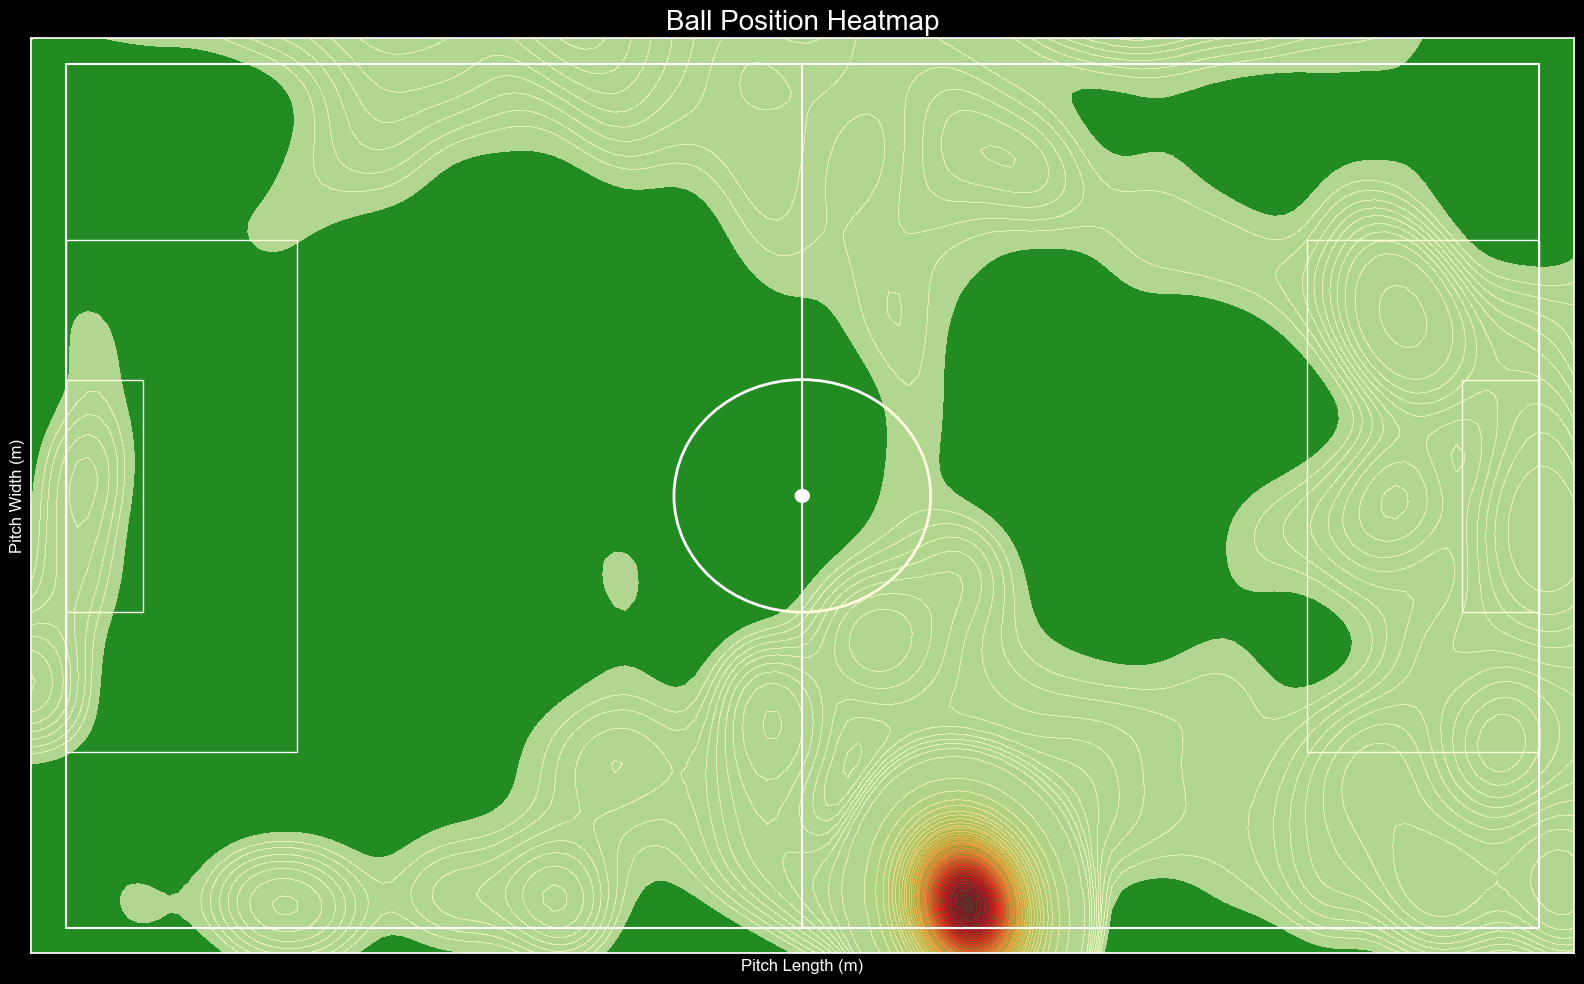

In [13]:
ball_df = df[df['participation_id'] == 'ball'].copy()

# Applying a smoothing filter to the ball's coordinates for a cleaner heatmap
# (This is the same process used for players)
fs = 10.0  # Sampling frequency
fc = 1.2   # Cutoff frequency
order = 2
Wn = fc / (fs / 2)
b, a = butter(order, Wn, btype='low')
ball_df['x_smooth'] = filtfilt(b, a, ball_df['Pitch_x'])
ball_df['y_smooth'] = filtfilt(b, a, ball_df['Pitch_y'])


# --- Utility function to draw the pitch ---
def draw_pitch(ax, pitch_color='#228B22', line_color='white'):
    """
    Draws a football pitch on a matplotlib axes object.
    """
    ax.set_facecolor(pitch_color)
    
    # Pitch Outline & Halfway Line
    ax.plot([0, 0], [-34, 34], color=line_color) # Halfway line
    ax.plot([-52.5, 52.5], [-34, -34], color=line_color) # Bottom line
    ax.plot([-52.5, 52.5], [34, 34], color=line_color)   # Top line
    ax.plot([-52.5, -52.5], [-34, 34], color=line_color) # Left line
    ax.plot([52.5, 52.5], [-34, 34], color=line_color)   # Right line
    
    # Center Circle
    center_circle = Circle((0.0, 0.0), 9.15, edgecolor=line_color, facecolor='none', lw=2)
    ax.add_patch(center_circle)
    center_dot = Circle((0.0, 0.0), 0.5, color=line_color)
    ax.add_patch(center_dot)
    
    # Penalty Areas
    ax.add_patch(Rectangle((-52.5, -20.15), 16.5, 40.3, edgecolor=line_color, facecolor='none'))
    ax.add_patch(Rectangle((36, -20.15), 16.5, 40.3, edgecolor=line_color, facecolor='none'))
    
    # 6-yard Box
    ax.add_patch(Rectangle((-52.5, -9.16), 5.5, 18.32, edgecolor=line_color, facecolor='none'))
    ax.add_patch(Rectangle((47, -9.16), 5.5, 18.32, edgecolor=line_color, facecolor='none'))

    return ax

# --- 1. Create the Plot ---
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(16, 10))
plt.style.use('dark_background')

# --- 2. Draw the Pitch ---
# Use the function to draw a pitch as the background
ax = draw_pitch(ax)

# --- 3. Generate and Overlay the Ball Heatmap ---
# Use seaborn's Kernel Density Estimate (KDE) plot.
# The only change from your code is using ball_df['x_smooth'] and ball_df['y_smooth']
sns.kdeplot(
    x=ball_df['x_smooth'],
    y=ball_df['y_smooth'],
    fill=True,
    cmap="YlOrRd",  # A yellow-orange-red colormap works well for balls
    n_levels=50,
    alpha=0.65, # Set transparency to see the pitch lines underneath
    ax=ax
)

# --- 4. Final Touches ---
ax.set_xlim(-55, 55)
ax.set_ylim(-36, 36)
ax.set_title('Ball Position Heatmap', fontsize=20, color='white')
ax.set_xlabel('Pitch Length (m)', color='white')
ax.set_ylabel('Pitch Width (m)', color='white')

# Remove axis ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()


### Ball Possession Analysis

Total time in possession: 159.2s
Total time out of possession (ball is loose): 6364.2s


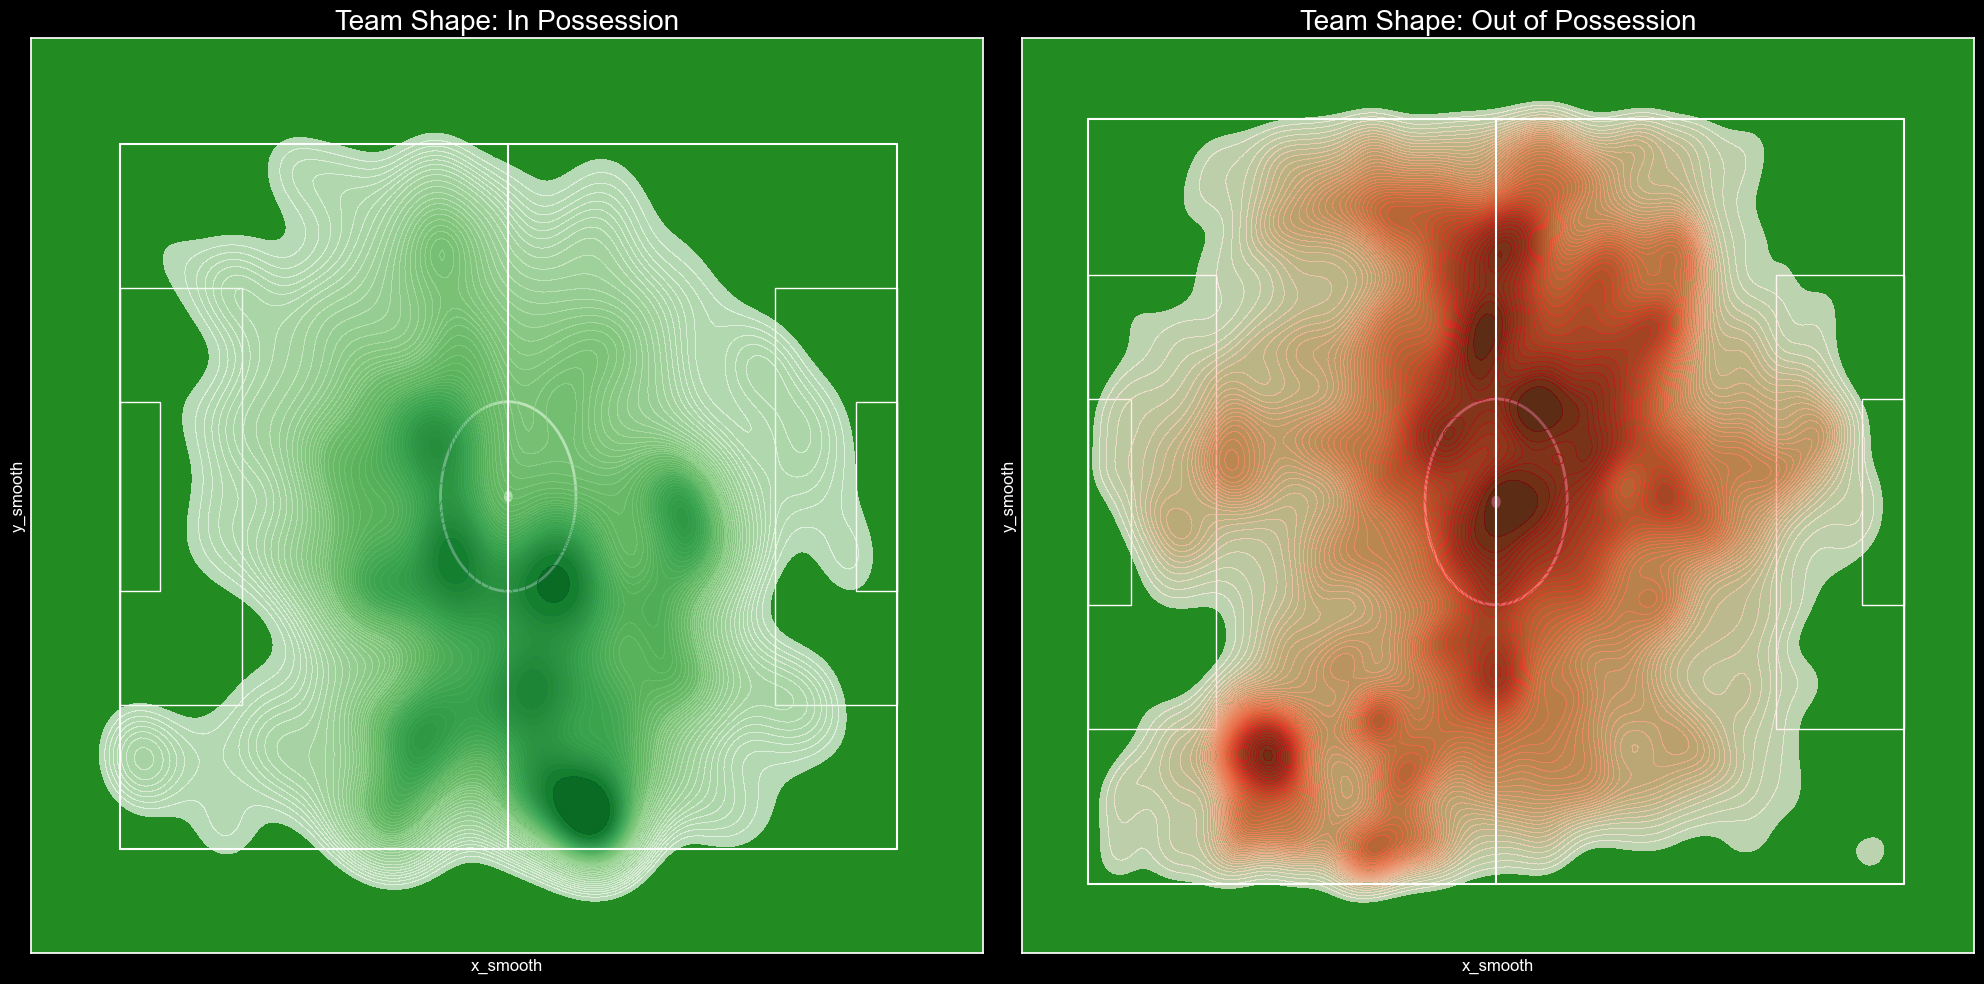

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Arc, Rectangle, Circle

# --- Part 1: Assign Possession based on Proximity ---
# To create these heatmaps, we first need to determine when the team is in possession.
# Assumption: The player closest to the ball, within a certain threshold, is in possession.

POSSESSION_THRESHOLD_M = 2.5 # Player must be within 2.5 meters to be considered in possession

# Merge player and ball dataframes on the timestamp to calculate distances
# Using merge_asof is efficient for time-series data. The tolerance is now a float to match the 'Time (s)' column.
merged_df = pd.merge_asof(
    players_df.sort_values('Time (s)'),
    ball_df[['Time (s)', 'x_smooth', 'y_smooth']].sort_values('Time (s)').rename(columns={'x_smooth': 'ball_x', 'y_smooth': 'ball_y'}),
    on='Time (s)',
    direction='nearest',
    tolerance=0.1 # CORRECTED: Tolerance is now a float (0.1 seconds)
).dropna()

# Calculate the distance from each player to the ball for every timestamp
merged_df['distance_to_ball'] = np.sqrt(
    (merged_df['x_smooth'] - merged_df['ball_x'])**2 + (merged_df['y_smooth'] - merged_df['ball_y'])**2
)

# For each timestamp, find the minimum distance from ANY player to the ball
min_dist_per_timestep = merged_df.groupby('Time (s)')['distance_to_ball'].min()

# Identify the timestamps where the team is considered in possession
in_possession_times = min_dist_per_timestep[min_dist_per_timestep < POSSESSION_THRESHOLD_M].index
out_of_possession_times = min_dist_per_timestep[min_dist_per_timestep >= POSSESSION_THRESHOLD_M].index

# Filter the original player dataframe based on these possession timestamps
in_possession_df = players_df[players_df['Time (s)'].isin(in_possession_times)]
out_of_possession_df = players_df[players_df['Time (s)'].isin(out_of_possession_times)]

print(f"Total time in possession: {len(in_possession_times) / 10:.1f}s")
print(f"Total time out of possession (ball is loose): {len(out_of_possession_times) / 10:.1f}s")


# --- Part 2: Visualize In-Possession vs. Out-of-Possession Heatmaps ---
# Create a figure with two subplots to compare the heatmaps side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.style.use('dark_background')

# --- In-Possession Heatmap (Left Plot) ---
ax1 = draw_pitch(axes[0])
sns.kdeplot(
    x=in_possession_df['x_smooth'],
    y=in_possession_df['y_smooth'],
    fill=True,
    cmap="Greens",
    n_levels=50,
    alpha=0.7,
    ax=ax1
)
ax1.set_title('Team Shape: In Possession', fontsize=20, color='white')
ax1.set_xticks([])
ax1.set_yticks([])

# --- Out-of-Possession Heatmap (Right Plot) ---
ax2 = draw_pitch(axes[1])
sns.kdeplot(
    x=out_of_possession_df['x_smooth'],
    y=out_of_possession_df['y_smooth'],
    fill=True,
    cmap="Reds",
    n_levels=50,
    alpha=0.7,
    ax=ax2
)
ax2.set_title('Team Shape: Out of Possession', fontsize=20, color='white')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()